In [ ]:
import os
from dotenv import find_dotenv, load_dotenv
from shapely.ops import orient

load_dotenv(find_dotenv())
src_path = os.environ.get("PROJECT_SRC")
os.chdir(src_path)

src_path

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.style.use("ggplot")
import generators
from data_reader_writer import data_writer

# Costing Analysis of 2030 Generation

In [38]:
year = 20305
FES_scenario = "Leading The Way"
FES_year = 2022
euro_to_gbp = 1.20
hours_in_year = 24 * 365

In [39]:
PV_investment: dict[str, float] = {
    "PV module": 0.11 * 10 ** 6,  # euro/MW
    "Inverter": 0.02 * 10 ** 6,  # euro/MW
    "Transformer": 0.04 * 10 ** 6,  # euro/MW
    "Installation": 0.08 * 10 ** 6,  # euro/MW
    "Soft costs": 0.02 * 10 ** 6,  # euro/MW
    "Residual balance of plant, mark-up & contingency cost": 0.03 * 10 ** 6,  # euro/MW
}

ccgt_investment: dict[str, float] = {
    "Equipment nominal investment": 0.64 * 10 ** 6,  # euro/MW
    "Installation nominal investment": 0.19 * 10 ** 6,  # euro/MW
    "Fixed O&M per year": 27_800,  # euro/MW
}

wind_offshore_investment: dict[str, float] = {
    "Fixed bottom cost per year": 39_000,  # euro/MW
}

wind_onshore_investment: dict[str, float] = {
    "Equipment nominal investment": 0.978 * 10 ** 6,  # euro/MW
    "Installation nominal investment": 0.101 * 10 ** 6,  # euro/MW
    "Grid connection nominal investment": 0.019 * 10 ** 6,  # euro/MW
    "Land purchase nominal investment": 0.122 * 10 ** 6,  # euro/MW
    "Decommissioning existing turbines": 0.035 * 10 ** 6,  # euro/MW
    "Purchase of neighbour settlements": 0.077 * 10 ** 6,  # euro/MW
    "Fixed O&M per year": 19_676,  # euro/MW
}

biomass_investment: dict[str, float] = {
    "Equipment nominal investment": 6.00 * 10 ** 6,  # euro/MW
    "Installation nominal investment": 3.70 * 10 ** 6,  # euro/MW
    "Fixed O&M per year": 273_000,  # euro/MW
}

nuclear_investment: dict[str, float] = {
    "yes": 0
}

In [40]:
PV: dict[str, float] = {
    "investment": 543.3289 * 1000,  # euro/MW
}

ccgt: dict[str, float] = {
    "investment": 878.324 * 1000,  # euro/MW
    "fuel": 24.568,  # euro/MWh
    "efficiency": 0.58
}

wind_offshore: dict[str, float] = {
    "investment": 1682.1226 * 1000,  # euro/MW
    "ac_station_investment": 264.5554 * 1000,  # euro/MW
}

wind_onshore: dict[str, float] = {
    "investment": 1095.8533 * 1000,  # euro/MW
}

biomass: dict[str, float] = {
    "investment": 2337.6116 * 1000,  # euro/MW
    "fuel": 7.406,  # euro/MWh
    "efficiency": 0.468
}

nuclear: dict[str, float] = {
    "investment": 8594.1354 * 1000,  # euro/MW
    "fuel": 3.41222,  # euro/MWh
    "efficiency": 0.326
}

## FES Data

In [41]:
scenarios = ["Leading The Way", "Consumer Transformation", "System Transformation", ]
time_step = 1.0

In [42]:
year = 2025
start = str(year) + '-12-02 00:00:00'
end = str(year) + '-12-02 03:30:00'
if year > 2020:
    data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=2012, scenario=scenarios[0],
                FES=2022)
if year <= 2020:
    data_writer(start, end, time_step, year, demand_dataset='historical')
df_generators_2025 = pd.read_csv('LOPF_data/generators.csv', index_col=0)

# 2030
year = 2030
start = str(year) + '-12-02 00:00:00'
end = str(year) + '-12-02 03:30:00'
if year > 2020:
    data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=2012, scenario=scenarios[0],
                FES=2022)
if year <= 2020:
    data_writer(start, end, time_step, year, demand_dataset='historical')
df_generators_2030 = pd.read_csv('LOPF_data/generators.csv', index_col=0)

C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_point = {'lon': df['x'][i], 'lat': df['y'][i]}
C:\Programming\PyPSA-GB_2030\PyPSA-GB\generators.py:795: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.index = pd.to_datetime(df.index, infer_datetime_format=True)
C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

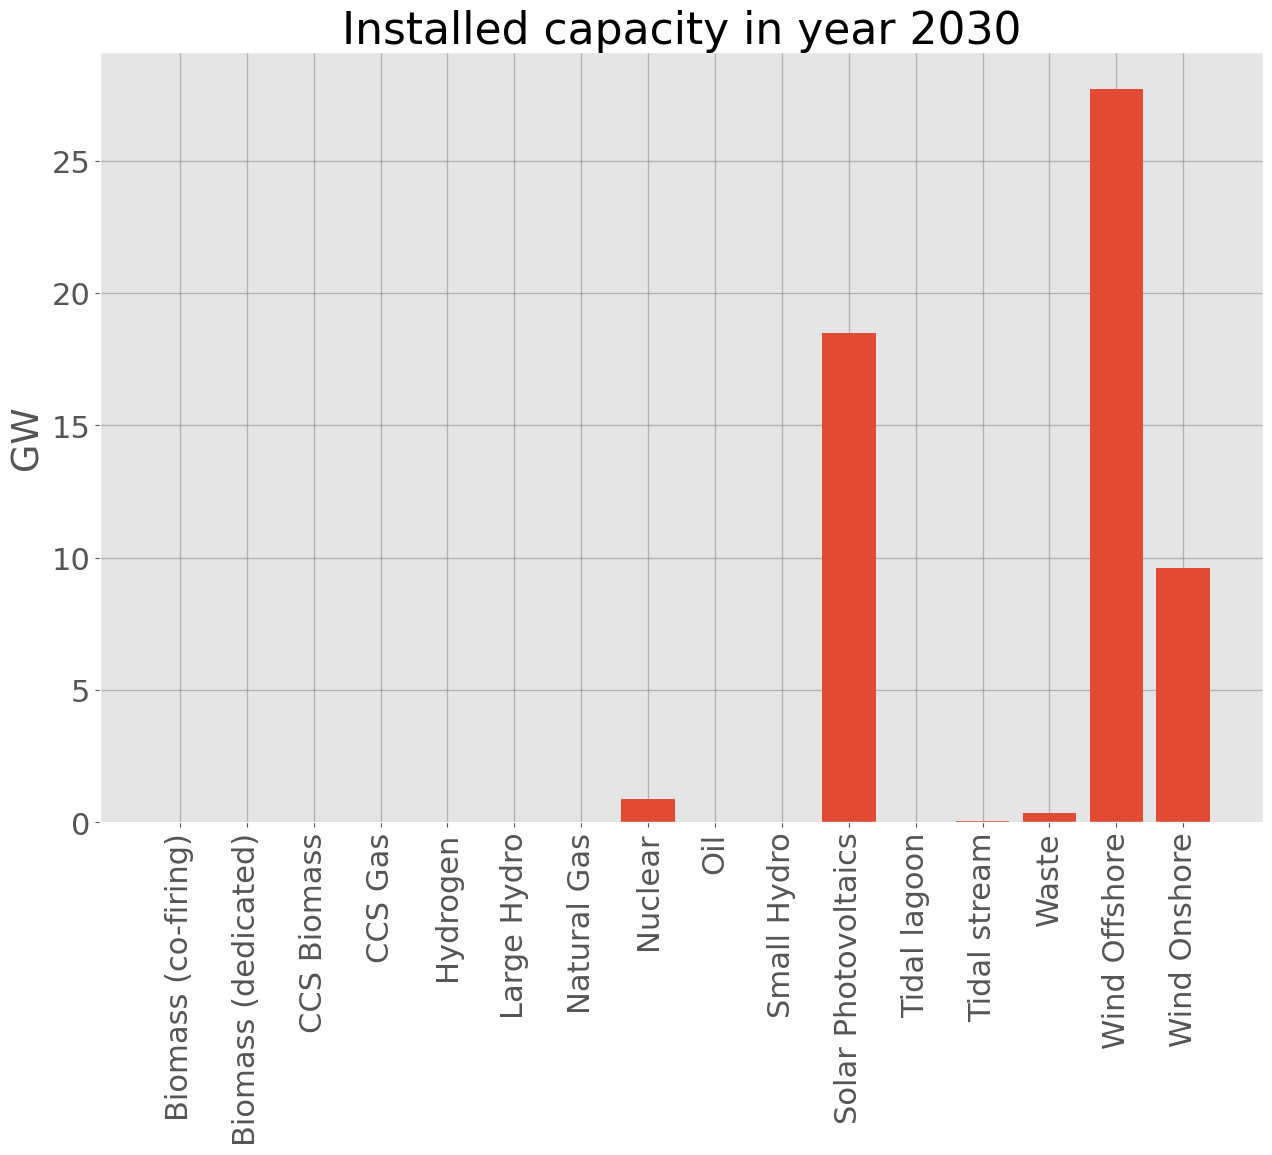

In [43]:
generators_p_nom_2025 = df_generators_2025.p_nom.groupby(df_generators_2025.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom_2025.drop('Unmet Load', inplace=True)
generators_p_nom_2025.drop(generators_p_nom_2025[generators_p_nom_2025 < 50].index, inplace=True)

generators_p_nom_2030 = df_generators_2030.p_nom.groupby(df_generators_2030.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom_2030.drop('Unmet Load', inplace=True)
generators_p_nom_2030.drop(generators_p_nom_2030[generators_p_nom_2030 < 50].index, inplace=True)

difference_gen_p_nom = (generators_p_nom_2030 - generators_p_nom_2025).clip(lower=0.0)
# print((generators_p_nom_2030 - generators_p_nom_2025).clip(lower=0.0))

plt.rcParams.update({'font.size': 22})
# bar chart
plt.figure(figsize=(15, 10))
plt.bar(difference_gen_p_nom.index, difference_gen_p_nom.values / 1000)
plt.xticks(difference_gen_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Increased capacity by year ' + str(year))
plt.show()

In [55]:
solar_cost: float = 0.00
offshore_cost: float = 0.00
onshore_cost: float = 0.00
biomass_cost: float = 0.00
ccgt_cost: float = 0.00
nuclear_cost: float = 0.00

biomass_fuel: float = 0.00
ccgt_fuel: float = 0.00
nuclear_fuel: float = 0.00

for gen_tech in generators_p_nom_2030.index:
    if gen_tech == "Solar Photovoltaics":
        solar_cost += PV["investment"] * generators_p_nom_2030["Solar Photovoltaics"]

    if gen_tech == "Wind Offshore":
        offshore_cost += wind_offshore["investment"] * generators_p_nom_2030["Wind Offshore"]

    if gen_tech == "Wind Onshore":
        onshore_cost += wind_onshore["investment"] * generators_p_nom_2030["Wind Onshore"]

    if gen_tech == "Biomass (dedicated)":
        biomass_cost += biomass["investment"] * generators_p_nom_2030["Biomass (dedicated)"]
        biomass_fuel += biomass["fuel"] * biomass["efficiency"] * generators_p_nom_2030[
            "Biomass (dedicated)"] * hours_in_year

    if gen_tech == "Natural Gas":
        ccgt_cost += ccgt["investment"] * generators_p_nom_2030["Natural Gas"]
        ccgt_fuel += ccgt["fuel"] * ccgt["efficiency"] * generators_p_nom_2030["Natural Gas"] * hours_in_year

    if gen_tech == "Nuclear":
        nuclear_cost += nuclear["investment"] * generators_p_nom_2030["Nuclear"]
        nuclear_fuel += nuclear["fuel"] * nuclear["efficiency"] * generators_p_nom_2030["Nuclear"] * hours_in_year

solar_cost *= euro_to_gbp
offshore_cost *= euro_to_gbp
onshore_cost *= euro_to_gbp
biomass_cost *= euro_to_gbp
ccgt_cost *= euro_to_gbp
nuclear_cost *= euro_to_gbp

biomass_fuel *= euro_to_gbp
ccgt_fuel *= euro_to_gbp
nuclear_fuel *= euro_to_gbp

headers = ["Technology", "Cost [B£]"]
headers_fuel = ["Technology", "Fuel Cost [M£/year]"]

table_data = [
    ["Solar Photovoltaics", solar_cost / 1e9],
    ["Wind Offshore", offshore_cost / 1e9],
    ["Wind Onshore", onshore_cost / 1e9],
    ["Biomass (dedicated)", biomass_cost / 1e9],
    ["Natural Gas", ccgt_cost / 1e9],
    ["Nuclear", nuclear_cost / 1e9],
]

table_data_fuel = [
    ["Biomass (dedicated)", biomass_fuel / 1e6],
    ["Natural Gas", ccgt_fuel / 1e6],
    ["Nuclear", nuclear_fuel / 1e6],
]

print(tabulate(table_data, headers=headers, tablefmt="pipe", stralign="center", numalign="center"))  # "grid" format
print("\n")
print(tabulate(table_data_fuel, headers=headers_fuel, tablefmt="pipe", stralign="center",
               numalign="center"))  # "grid" format

|     Technology      |  Cost [B£]  |
|:-------------------:|:-----------:|
| Solar Photovoltaics |   27.3813   |
|    Wind Offshore    |   102.84    |
|    Wind Onshore     |   40.4642   |
| Biomass (dedicated) |   11.2235   |
|     Natural Gas     |   13.8061   |
|       Nuclear       |   47.1302   |


|     Technology      |  Fuel Cost [M£/year]  |
|:-------------------:|:---------------------:|
| Biomass (dedicated) |        145.777        |
|     Natural Gas     |        1962.08        |
|       Nuclear       |        53.4387        |


## Neso Data Further Flex

In [52]:
gen_data: dict[str, float] = {
    "Solar Photovoltaics": 47.4 * 10 ** 3,  # MW
    "Wind Offshore": 50.6 * 10 ** 3,  # MW
    "Wind Onshore": 27.3 * 10 ** 3,  # MW
    "Biomass (dedicated)": 4.0 * 10 ** 3,  # MW
    "Natural Gas": 35.0 * 10 ** 3,  # MW
    "Nuclear": 3.5 * 10 ** 3,  # MW
    "Hydrogen": 0.3 * 10 ** 3,  # MW
}

df_neso_ff = pd.DataFrame(gen_data.items(), columns=["Technology", "Capacity [MW]"].set_index("Technology"))
df_neso_ff

AttributeError: 'list' object has no attribute 'set_index'

In [ ]:
for gen_tech in df_neso_ff.index:
    if gen_tech == "Solar Photovoltaics":
        solar_cost += PV["investment"] * generators_p_nom_2030["Solar Photovoltaics"]

    if gen_tech == "Wind Offshore":
        offshore_cost += wind_offshore["investment"] * generators_p_nom_2030["Wind Offshore"]

    if gen_tech == "Wind Onshore":
        onshore_cost += wind_onshore["investment"] * generators_p_nom_2030["Wind Onshore"]

    if gen_tech == "Biomass (dedicated)":
        biomass_cost += biomass["investment"] * generators_p_nom_2030["Biomass (dedicated)"]
        biomass_fuel += biomass["fuel"] * biomass["efficiency"] * generators_p_nom_2030[
            "Biomass (dedicated)"] * hours_in_year

    if gen_tech == "Natural Gas":
        ccgt_cost += ccgt["investment"] * generators_p_nom_2030["Natural Gas"]
        ccgt_fuel += ccgt["fuel"] * ccgt["efficiency"] * generators_p_nom_2030["Natural Gas"] * hours_in_year

    if gen_tech == "Nuclear":
        nuclear_cost += nuclear["investment"] * generators_p_nom_2030["Nuclear"]
        nuclear_fuel += nuclear["fuel"] * nuclear["efficiency"] * generators_p_nom_2030["Nuclear"] * hours_in_year